# Correlating Company Reseach Report with Stock Price

# Importing all dependencies
After comparing all deep learning frameworks, we adopted Keras [1] as it provides the highest level of abstraction and convenience.
[1]: https://github.com/fchollet/keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

from keras import backend as K
from keras.utils import plot_model, to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D

from visualizations import plot_confusion_matrix, plot_learning_curve

# Set default size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# For reproducibility
np.random.seed(2017)

Using TensorFlow backend.


# Load All Data and Define Useful Parameters
- After experimenting with different combinations, we selected name of target company, number of increase-related word, number of positive sentences, number of negative sentences, overall mean of sentences as our features as they provide the best performance for our model. 
- Mean normalization and feature scaling have already been introduced to the data loaded

In [2]:
# Load data
X = np.load('C:\\Users\\wywongbd\\Desktop\\test2\\traders_nlp\\input_data\\X_cnn.npy')
y = np.load('C:\\Users\\wywongbd\\Desktop\\test2\\traders_nlp\\input_data\\y_cnn.npy')

In [3]:
#####################
# Useful parameters #
#####################

# Maximum number of reports in a month for a particular company
sequence_len = X.shape[1]

# Number of features extracted from each report
num_features = X.shape[2]

# Number of predicted classes, which is 3 
num_classes = len(np.unique(y))

# Proportion of data used as training set
training_ratio = 0.65
num_trains = int(training_ratio * X.shape[0])

# Split into Training and Validation Set
We used a train-test ratio of 0.65:0.35 to split our dataset. Because our overall dataset is small, we had to reduce the variance   in   our   testing   performance   statistic.

In [4]:
# Separate into training and testing set
X_train, y_train = X[:num_trains], y[:num_trains]
X_test, y_test = X[num_trains:], y[num_trains:]

# Convert class vectors to one-hot matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [5]:
# Necessary transformation
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, sequence_len, num_features)
    X_test = X_test.reshape(X_test.shape[0], 1, sequence_len, num_features)
else:
    X_train = X_train.reshape(X_train.shape[0], sequence_len, num_features, 1)
    X_test = X_test.reshape(X_test.shape[0], sequence_len, num_features, 1)
    
cnn_input_shape = X_train.shape[1:]

# Build Model
We experimented with different models, such as fully connected neural network, recurrent neural network (RNN) and convolutional neural network (CNN). We adopted CNN for its best performance and fastest training speed. As compared with other machine learning models, CNN is not only well known for its superior performance in image classification   [2], but also   in   other   artificial   intelligence   tasks   such   as   pattern   recognition   and   language   translation [3].

There are 386 data points and 3 output classes in our model. However, there are 715 trainable parameters in our architecture, which are roughly two times the total number of data points we have. It is seemingly insufficient   to   learn   so   many   parameters   without   considerable   overfitting.

In our dataset, it is essential to reduce overfitting due to the large variation in different company, report issuer, period of time and many other factors. To solve this, we use a dropout rate of 20% after every layer, due to its well known property   to   provide   regularization   [4].

With GPU acceleration, the training process takes around 1 minute for 300 epochs.

[2]: http://delivery.acm.org/10.1145/3070000/3065386/p84-krizhevsky.pdf?ip=175.159.122.118&id=3065386&acc=OA&key=CDD1E79C27AC4E65%2EFC30B8D6EF32B758%2E4D4702B0C3E38B35%2E5945DC2EABF3343C&CFID=993083882&CFTOKEN=79808059&__acm__=1507501880_53be17f837d24e1f3a1669844e808854
[3]:  http://arxiv.org/abs/1611.02344
[4]: http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

In [11]:
###########################
# Build and train the CNN #
###########################

# Initialize model
model = Sequential()

# Layer1 (Convolutional and pooling layer)
model.add(Conv2D(8, (2, 2), strides=1, activation='relu', input_shape=cnn_input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 2 (Convolutional and pooling layer)
model.add(Conv2D(8, (2, 2), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 3 (Fully connected layer)
model.add(Flatten())  # Convert 3D matricx to 1D vector before going in fully connected layers
model.add(Dense(4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 4 (Softmax layer)
model.add(Dense(num_classes, activation='softmax'))

# Build model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model and return training history
history = model.fit(X_train, y_train, batch_size=30, epochs=300, verbose=1, validation_data=(X_test, y_test))

Train on 250 samples, validate on 136 samples
Epoch 1/300
250/250 [==============================] - 0s - loss: 1.5400 - acc: 0.3680 - val_loss: 2.3605 - val_acc: 0.0956
Epoch 2/300
250/250 [==============================] - 0s - loss: 1.4886 - acc: 0.3880 - val_loss: 1.9932 - val_acc: 0.1250
Epoch 3/300
250/250 [==============================] - 0s - loss: 1.4503 - acc: 0.3960 - val_loss: 1.7769 - val_acc: 0.2132
Epoch 4/300
250/250 [==============================] - 0s - loss: 1.4299 - acc: 0.4440 - val_loss: 1.6418 - val_acc: 0.2500
Epoch 5/300
250/250 [==============================] - 0s - loss: 1.2912 - acc: 0.4360 - val_loss: 1.5521 - val_acc: 0.2941
Epoch 6/300
250/250 [==============================] - ETA: 0s - loss: 1.5413 - acc: 0.3333

# Evalution of Model
We tested our model on 136 samples and obtained the confusion as shown above. The model achieved 52.21% accuracy in classifying three classes.

In [12]:
# Print statistics for the best model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.898891624282
Test accuracy: 0.522058823529


# Confusion Matrix
As shown in the confusion matrix below, the model does not perform well in classifying class 1 and 2. This is
because   the   distribution   of   overall   dataset   is   skewed   towards   class   0,   and   the   occurrence   of   class   2   is   very   low.

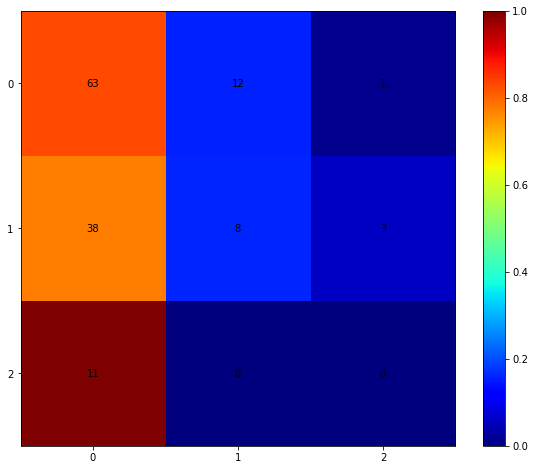

In [13]:
# Get confusion matrix
y_pred = model.predict(X_test)
y_pred_inverse = np.argmax(y_pred, axis = 1)
y_test_inverse = np.argmax(y_test, axis = 1)
confusion_matrix = metrics.confusion_matrix(y_test_inverse, y_pred_inverse)

# Print confusion matrix
plot_confusion_matrix(confusion_matrix)

# Learning Curve
After   significant     efforts   in   fine   tuning   the   architecture   and   hyperparameter   of   our   model,   we   obtained   the   learning
curves as shown below. The   training   and   validation   accuracy   converged   and   remained   stable over   time,   indicating   that   our   model   was   fully   trained   and   did   not   overfit   the   training   set.   The curve for model loss   shows   that   the   loss decreased   exponentially,   which   concludes   that   the   learning   rate   of   the   model   was   high,   providing   a   fast   training speed.

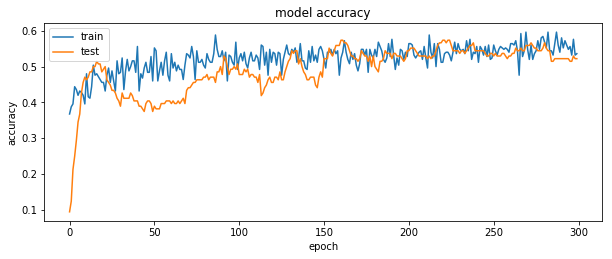

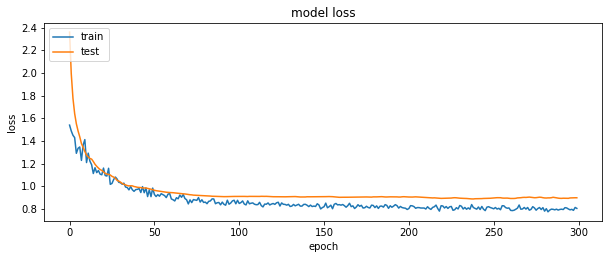

In [16]:
# Plot the train/validation loss and accuracies
plot_learning_curve(history)